# What do lightcurves look like in the calexps versus the difference images?

## RERUN with DC2 in February 2022
## February 2020 Analysis Sprint

For observations of transients, we can measure the accuracy of the calibration by looking at the "lightcurves" of static objects. There are two questions that we wish to answer: first, how do the magnitudes of stars in individual exposures compare to the magnitudes of the stars in the coadded image catalogs; second, what do we measure using forced photometry at the position of the stars in the difference imaging?

If the calibration could be done perfectly, we would expect to measure the same magnitude for a given star in all calexps and in the coadded image. Similarly, if the subtraction was perfect, we would measure zero flux at the star position in the difference images (assuming no true transient was present nearby). In reality, we aim to have results consistent with the ideal scenario to within error bars. 

~~We will check this with difference imaging produced in `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/ap_pipe_I`, with the forced photometry in `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_src_dir` for the calexps and `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim` for the difference images. For this preliminary analysis, we just look at one patch in COSMOS in the HSC-I band.~~

We will check this with difference imaging produced in the 5 year production from DC2 in tract 4431.

In [2]:
#from lsst.daf.persistence import Butler
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.geom as geom
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import scipy.stats
import os.path

In [25]:
# This one has 5-year results, but the right catalogs apparently weren't produced:
#butler = Butler('/repo/dc2', collections="u/kherner/2.2i/runs/test20210807-tract4431-w32-step5")
butler = Butler('/repo/dc2', collections="2.2i/runs/test-med-1/w_2022_03/DM-33223")

In [31]:
# Get the coadded image
tract = 3828
patch = 34
band = 'i'
skymap = 'DC2'

In [95]:
zeropoint = 27

### Get the forced photometry measurements in the coadd:

In [61]:
refCatalog = butler.get('objectTable', patch=patch, tract=tract, skymap='DC2')

In [30]:
len(refCatalog)

29913

### Get the forced photometry measurements in individual calexps and diffims:

In [32]:
## New Gen3 version:
forced_src = butler.get('forcedSourceTable', tract=tract, skymap=skymap, patch=patch)

### Get seeing information

In [33]:
# Gen3 version:
ccdVisitTable = butler.get('ccdVisitTable')

### Calculate average object fluxes and magnitudes from the calexps and diffims

In [91]:
n = int(500)

In [173]:
avg_df = pd.DataFrame(index=refCatalog[::10][:n].index,
                      columns=['refFlux', 'refMag',
                               'calexpFlux', 'calexpFluxStd', 'calexpMag', 'calexpMagStd',
                               'diffFlux', 'diffFluxStd', 'diffMag', 'diffMagStd'])

In [311]:
for r, rc in refCatalog[::10][:n].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == r) & (forced_src['band'] == band)]
    
    calexp_weight = rc_match['psfFluxErr']**-2
    calexp_avg_flux = np.average(rc_match['psfFlux'], weights=calexp_weight)
    
    calexp_var = np.average((rc_match['psfFlux'] - calexp_avg_flux)**2, weights=calexp_weight)
    calexp_std = calexp_var**0.5
    
    avg_df.loc[r]['calexpFlux'] = calexp_avg_flux
    avg_df.loc[r]['calexpFluxStd'] = calexp_std
    
    diff_weight = rc_match['psfFluxErr']**-2
    diffMask = np.isfinite(rc_match['psfDiffFlux'])
    if diffMask.any():
        diff_avg_flux = np.average(rc_match['psfDiffFlux'][diffMask], weights=rc_match['psfDiffFluxErr'][diffMask]**-2)
        
        diff_var = np.average((rc_match['psfDiffFlux'] - diff_avg_flux)**2, weights=diff_weight)
        diff_std = diff_var**0.5

        avg_df.loc[r]['diffFlux'] = diff_avg_flux
        avg_df.loc[r]['diffFluxStd'] = diff_std
        
    ref_mag = (rc[f'{band}_psfFlux'] * u.nJy).to(u.ABmag).to_value()
    if not (rc_match['psfFlux'] < 0).any():
        calexp_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
        calexp_magWeights = (((np.log(10)/2.5)**2) / (rc_match['psfFluxErr']**-2 * rc_match['psfFlux']**2))**-1
        calexp_avg_mag = np.average(calexp_mags, weights = calexp_magWeights)
        print(calexp_avg_mag)
        calexp_magvar = np.average((calexp_mags - calexp_avg_mag)**2, weights=calexp_magWeights)
        calexp_magstd = calexp_magvar**0.5
        
        avg_df.loc[r]['calexpMag'] = calexp_avg_mag
        avg_df.loc[r]['calexpMagStd'] = calexp_magstd
        
    if ((rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux']) > 0).all() and diffMask.any():
        #diff_mags = (((rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux'])/
        #             rc[f'{band}_psfFlux']).to_numpy() * u.nJy).to(u.ABmag).to_value()
        dmags = ((rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux']).to_numpy() * u.nJy).to(u.ABmag).to_value()
        diff_mags = dmags - ref_mag
        diff_magWeights = (((np.log(10)/2.5)**2) / (rc_match['psfDiffFluxErr']**-2 * (rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux'])**2))**-1
        diff_avg_mag = np.average(diff_mags[diffMask], weights = diff_magWeights[diffMask])
    
        diff_magvar = np.average((diff_mags - diff_avg_mag)**2, weights=diff_magWeights)
        diff_magstd = diff_magvar**0.5
        
        avg_df.loc[r]['diffMag'] = diff_avg_mag
        avg_df.loc[r]['diffMagStd'] = diff_magstd
    

    avg_df.loc[r]['refFlux'] = rc[f'{band}_psfFlux']
    
    avg_df.loc[r]['refMag'] = ref_mag
    
    print(r, len(rc_match))


22.08390591549165
1650199827524354049 35
1650199827524354059 36
1650199827524354069 37
1650199827524354080 36
1650199827524354090 32
1650199827524354100 38
23.66857276620119
1650199827524354111 37
1650199827524354121 37
22.5627469053319
1650199827524354134 36
24.231482456129857
1650199827524354144 38
23.75282125666822
1650199827524354154 32
1650199827524354170 36
1650199827524354182 37
1650199827524354192 37
1650199827524354206 35
24.04154363594572
1650199827524354217 36
1650199827524354230 37
1650199827524354240 35
1650199827524354251 37
1650199827524354262 34
20.3646689123671
1650199827524354272 35
20.743263315122135
1650199827524354283 35
1650199827524354294 34
22.882109827835414
[0.04417257 0.04165694 0.04909243 0.03803808 0.1182396 ]
forcedSourceId
230044890824710852    0.044173
253396093289636405    0.041657
93702232586856389     0.049092
232981580082059040    0.038038
213315462241460707    0.118240
Name: psfDiffFlux, dtype: float64
1650199827524354306 35
22.506260795091414
[-0.0

1650199827524355520 36
23.95342991489241
1650199827524355532 34
22.51459243047745
1650199827524355543 34
1650199827524355553 35
22.905297547977074
1650199827524355564 34
1650199827524355576 36
1650199827524355588 34
1650199827524355598 38
1650199827524355610 35
1650199827524355621 35
1650199827524355634 33
21.937924013089578
[ 0.02681628 -0.02573584 -0.03828988 -0.03165324 -0.01435011]
forcedSourceId
230044890824711427    0.026816
253396093289637368   -0.025736
232981580082059888   -0.038290
213315462241461629   -0.031653
122380275219958591   -0.014350
Name: psfDiffFlux, dtype: float64
1650199827524355644 34
22.889732208179193
1650199827524355656 34
22.95611041309034
[-0.111639    0.09508006  0.02099286 -0.01531386 -0.15607072]
forcedSourceId
230044890824711438   -0.111639
253396093289637383    0.095080
232981580082059904    0.020993
213315462241461643   -0.015314
122380275219958609   -0.156071
Name: psfDiffFlux, dtype: float64
1650199827524355668 34
1650199827524355678 35
165019982752

1650199827524356794 34
22.088376165786457
[-0.00042377  0.11758583  0.00249092 -0.01147269 -0.01197822]
forcedSourceId
230044890824711914   -0.000424
232981580082060743    0.117586
93702234197464154     0.002491
213315463852065225   -0.011473
141439727319388482   -0.011978
Name: psfDiffFlux, dtype: float64
1650199827524356805 33
23.67994896754463
1650199827524356815 36
1650199827524356826 30
23.989271438940722
[-0.2565403  -0.10351177 -0.36279634 -0.1418164  -0.50592455]
forcedSourceId
230044890824711928   -0.256540
232981580082060768   -0.103512
93702234197464174    -0.362796
213315463852065250   -0.141816
141439727319388502   -0.505925
Name: psfDiffFlux, dtype: float64
1650199827524356836 35
22.18336230716261
1650199827524356851 37
1650199827524356861 38
23.89281085927223
[-0.58204308 -0.54486617  0.16846435  0.56770353 -0.6934468 ]
forcedSourceId
230044891361575959   -0.582043
253396094900240760   -0.544866
232981580082060795    0.168464
213315463852065274    0.567704
14143972731938

1650199827524357833 33
1650199827524357844 34
22.917671902730604
[ 0.09969719 -0.0742819   0.14180184 -0.03816119 -0.06917598]
forcedSourceId
230044891361576387    0.099697
253396094900241305   -0.074282
93702234734330049     0.141802
232981581692665881   -0.038161
213315463852065962   -0.069176
Name: psfDiffFlux, dtype: float64
1650199827524357856 36
16.28596762792006
1650199827524357867 32
1650199827524357877 36
24.21293806734506
1650199827524357888 38
1650199827524357900 30
1650199827524357912 33
1650199827524357923 33
23.353400424015344
1650199827524357936 34
1650199827524357947 31
1650199827524357958 37
1650199827524357968 35
1650199827524357979 36
23.474830632404274
[-0.2579676   0.02625949 -0.25554782  0.08101766  0.07747662]
forcedSourceId
230044891361576444   -0.257968
253396094900241392    0.026259
93702234734330085    -0.255548
232981581692665899    0.081018
213315463852066051    0.077477
Name: psfDiffFlux, dtype: float64
1650199827524357993 38
23.94955714818119
165019982752

1650199827524359155 34
22.718221181975313
[ 0.0382082  -0.00814323 -0.08507254  0.08680094  0.0817502 ]
forcedSourceId
230044890824712806    0.038208
253396094900242318   -0.008143
232981580082062161   -0.085073
93702234197465472     0.086801
213315463852066839    0.081750
Name: psfDiffFlux, dtype: float64
1650199827524359167 32
1650199827524359178 37
1650199827524359188 36
1650199827524359198 33
24.023665452794855
1650199827524359209 37
23.582240431931766
1650199827524359220 34
1650199827524359231 36
1650199827524359242 32
1650199827524359253 36
1650199827524359264 37
21.46485715238575
1650199827524359274 33
1650199827524359285 36
22.4035070392585
[-0.00274825  0.02159199 -0.03262749 -0.04230014 -0.06542272]
forcedSourceId
230044890824712859   -0.002748
253396094900242435    0.021592
232981580082062223   -0.032627
93702234197465546    -0.042300
213315463852066931   -0.065423
Name: psfDiffFlux, dtype: float64
1650199827524359300 36
1650199827524359311 32
1650199827524359325 33
16501998

1650199827524360647 31
23.995267321004373
1650199827524360658 34
1650199827524360668 35
1650199827524360682 34
1650199827524360692 31
23.944149954913723
[-0.21921377  0.04274034 -0.45396944 -0.0274943  -0.26268294]
forcedSourceId
230044890824713380   -0.219214
253396094900243570    0.042740
93702234197466288    -0.453969
213315463852067863   -0.027494
141439725708772581   -0.262683
Name: psfDiffFlux, dtype: float64
1650199827524360703 34
23.7018310599185
1650199827524360714 33
23.227291958781592
1650199827524360731 33
21.96521231678845
1650199827524360743 36
23.09056587588812
1650199827524360753 33
1650199827524360764 32
1650199827524360776 36
1650199827524360790 35
1650199827524360804 35
1650199827524360818 28
1650199827524360831 31
23.060059222205165
1650199827524360842 36
1650199827524360853 35
1650199827524360865 35
1650199827524360877 36
1650199827524360887 29
22.517423490552424
1650199827524360899 34
1650199827524360910 32
1650199827524360920 28
1650199827524360932 34
16501998275

23.893720908879438
1650199827524362273 32
21.18861046744647
1650199827524362287 33
23.95180316116753
1650199827524362300 37
1650199827524362311 37
23.809372267311996
1650199827524362323 34
23.185751533839742
1650199827524362337 32
1650199827524362347 34
23.637468601613467
1650199827524362360 32
1650199827524362372 35
23.979768945347974
1650199827524362387 28
1650199827524362397 38
23.803189085412637
1650199827524362410 34
24.059116551155775
1650199827524362422 31
1650199827524362433 33
23.147815479369918
1650199827524362443 35
1650199827524362454 28
1650199827524362465 36
1650199827524362479 38
1650199827524362491 36
1650199827524362502 34
1650199827524362514 27
1650199827524362525 35
1650199827524362539 35
1650199827524362551 34
1650199827524362563 38
23.76771622250078
1650199827524362574 34
1650199827524362585 32
1650199827524362597 32
1650199827524362607 34
1650199827524362618 33
1650199827524362628 32
20.12507048335589
[ 0.02001735 -0.02170438 -0.02616747  0.00203701  0.00153137]
f

1650199827524365663 33
1650199827524365674 34
1650199827524365686 35
1650199827524365697 36
1650199827524365707 35
1650199827524365718 37
1650199827524365729 37
1650199827524365739 35
1650199827524365749 35
1650199827524365759 36
1650199827524365769 38
1650199827524365779 38
1650199827524365789 33
1650199827524365799 34
1650199827524365809 36
1650199827524365819 32
1650199827524365829 33
1650199827524365839 36
1650199827524365849 31
1650199827524365859 34
1650199827524365869 34
1650199827524365879 35
1650199827524365889 34
1650199827524365899 38
1650199827524365909 35
1650199827524365919 36
1650199827524365929 35
1650199827524365939 37
1650199827524365949 34
1650199827524365959 35
1650199827524365969 33
1650199827524365979 35
1650199827524365989 38
1650199827524365999 33
1650199827524366009 38
1650199827524366019 33
1650199827524366029 31
1650199827524366039 35
1650199827524366049 39
1650199827524366059 37
1650199827524366069 35
1650199827524366079 34
1650199827524366089 33
16501998275

1650199827524378438 37
1650199827524378448 35
1650199827524378458 32
1650199827524378468 38
1650199827524378478 39
1650199827524378488 37
1650199827524378498 34
1650199827524378508 33
24.268178462371957
1650199827524378518 37
1650199827524378528 34
1650199827524378538 33
1650199827524378548 35
1650199827524378558 35
1650199827524378568 38
1650199827524378578 32
1650199827524378588 35
23.735833771593338
[ 0.1029867   0.01281416 -0.03026477 -0.21235127 -0.35927614]
forcedSourceId
230044890824726464    0.102987
253396093289653675    0.012814
93702232586874518    -0.030265
232981580082074540   -0.212351
213315462241477216   -0.359276
Name: psfDiffFlux, dtype: float64
1650199827524378598 34
[-0.38096283 -0.57163541  0.26928263  0.73453622  0.00928598]
forcedSourceId
230044891361580807   -0.380963
253396093289653685   -0.571635
93702233123719536     0.269283
213315462241477226    0.734536
232981580618935904    0.009286
Name: psfDiffFlux, dtype: float64
1650199827524378608 36
1650199827524378

1650199827524380098 34
1650199827524380108 33
1650199827524380118 34
20.757068823638548
[-0.01377135  0.01834415 -0.0133546   0.0273495   0.02393316]
forcedSourceId
230044891361581508   -0.013771
253396093289654904    0.018344
93702232586875260    -0.013355
232981580082075662    0.027349
213315462241478423    0.023933
Name: psfDiffFlux, dtype: float64
1650199827524380128 34
1650199827524380138 34
1650199827524380148 35
1650199827524380158 35
1650199827524380168 33
1650199827524380178 34
1650199827524380188 33
22.915166922867137
1650199827524380198 32
1650199827524380208 33
1650199827524380218 34
1650199827524380228 34
24.047762005283044
1650199827524380238 33
1650199827524380248 34
1650199827524380258 35
21.52051370006356
1650199827524380268 34
1650199827524380278 34
1650199827524380288 36
1650199827524380298 35
1650199827524380308 33
23.256420271798536
[ 0.24285818  0.01380721 -0.13437688  0.07565846  0.11304784]
forcedSourceId
230044890824727299    0.242858
253396093289655042    0.01

24.023250535762596
[-0.00811956  0.08882111 -0.20857647 -0.01195828 -0.45073607]
forcedSourceId
230044890824727953   -0.008120
253396093289655810    0.088821
232981580082076996   -0.208576
93702234197478290    -0.011958
122380275219971013   -0.450736
Name: psfDiffFlux, dtype: float64
1650199827524381738 31
22.720548915126262
1650199827524381748 33
1650199827524381758 32
1650199827524381768 31
1650199827524381778 34
1650199827524381788 32
1650199827524381798 35
22.824163736872265
[ 0.04800965 -0.21502275  0.07412827  0.10102645  0.01437997]
forcedSourceId
230044891361582347    0.048010
253396094900250326   -0.215023
232981580082077055    0.074128
213315463852073440    0.101026
141439727319398178    0.014380
Name: psfDiffFlux, dtype: float64
1650199827524381808 35
1650199827524381818 34
1650199827524381828 36
1650199827524381838 35
1650199827524381848 34
21.37801161287981
[ 0.04043223  0.00804399 -0.02601504 -0.02560872  0.01798029]
forcedSourceId
230044890824728014    0.040432
253396093

1650199827524383338 38
1650199827524383348 31
1650199827524383358 38
1650199827524383368 39
1650199827524383378 34
23.90000166985889
[-0.20611202  0.06210409  0.28757317  0.09053446  0.21448854]
forcedSourceId
230044891361583074   -0.206112
253396094900251123    0.062104
232981580082078413    0.287573
93702234197479430     0.090534
213315463852074671    0.214489
Name: psfDiffFlux, dtype: float64
1650199827524383388 37
23.854297535890343
[-0.17713164 -0.07966594 -0.45365805  0.13793264 -0.13893879]
forcedSourceId
230044890824728767   -0.177132
232981580082078420   -0.079666
93702234197479436    -0.453658
213315463852074678    0.137933
122380275219972395   -0.138939
Name: psfDiffFlux, dtype: float64
1650199827524383398 33
1650199827524383408 35
1650199827524383418 36
21.695460988176425
[ 0.0073082   0.0468065   0.0120812   0.02730818 -0.0487017 ]
forcedSourceId
230044891361583104    0.007308
253396094900251158    0.046806
232981580082078444    0.012081
93702234197479460     0.027308
2133

1650199827524384418 36
1650199827524384428 38
23.18444294825967
1650199827524384438 33
1650199827524384448 37
1650199827524384458 35
1650199827524384468 35
1650199827524384478 35
1650199827524384488 33
1650199827524384498 34
1650199827524384508 37
22.364081957919158
1650199827524384518 33
1650199827524384528 33
1650199827524384538 38
1650199827524384548 38
1650199827524384558 35
23.388851122570195
1650199827524384568 35
1650199827524384578 35
1650199827524384588 33
1650199827524384598 34
24.25323482795907
1650199827524384608 33
1650199827524384618 34
23.379966630128827
[-0.26943035  0.01211235 -0.1270267  -0.11802637  0.07125379]
forcedSourceId
230044890824729315   -0.269430
253396094900252052    0.012112
232981580082079305   -0.127027
93702234197480223    -0.118026
213315463852075663    0.071254
Name: psfDiffFlux, dtype: float64
1650199827524384628 33
1650199827524384638 33
23.937650690103915
[-0.07202354  1.10959024  0.42293192 -0.56486232 -0.11222283]
forcedSourceId
2300448908247293

23.489042414347768
1650199827524385818 34
22.224525304800668
1650199827524385828 35
1650199827524385838 34
1650199827524385848 35
1650199827524385858 38
23.993337183185293
1650199827524385868 35
1650199827524385878 35
1650199827524385888 33
1650199827524385898 34
1650199827524385908 36
1650199827524385918 34
1650199827524385928 34
23.43442646848934
1650199827524385938 35
1650199827524385948 34
1650199827524385958 33
1650199827524385968 34
1650199827524385978 36
1650199827524385988 38
1650199827524385998 36
[ 0.87110844  0.03334738  0.26581678 -0.56659465  0.37079935]
forcedSourceId
230044890824729899    0.871108
253396094900253362    0.033347
232981580082080145    0.265817
93702234197481082    -0.566595
213315463315214291    0.370799
Name: psfDiffFlux, dtype: float64
1650199827524386008 33
1650199827524386018 36
1650199827524386028 34
1650199827524386038 33
1650199827524386048 35
1650199827524386058 35
23.384747300972027
[ 0.01766136  0.08577809  0.1327591  -0.2057282   0.06600549]
for

22.367761479851858
1650199827524387038 34
1650199827524387048 33
1650199827524387058 33
1650199827524387068 35
1650199827524387078 31
1650199827524387088 31
1650199827524387098 34
1650199827524387108 35
24.10439999045077
[-0.16122971  0.29244004 -0.39758649 -0.03052287  0.46797058]
forcedSourceId
230044890824730419   -0.161230
253396094900254439    0.292440
232981580082080737   -0.397586
93702234197481781    -0.030523
253499190221488789    0.467971
Name: psfDiffFlux, dtype: float64
1650199827524387118 32
1650199827524387128 31
23.908742581547756
[-0.08067766  0.27687402  0.43962626  0.01104328  0.15777841]
forcedSourceId
230044891361585018   -0.080678
253396094900254459    0.276874
93702234197481786     0.439626
213315463852077606    0.011043
141439725708782193    0.157778
Name: psfDiffFlux, dtype: float64
1650199827524387138 34
22.73989735567507
[-0.01630354 -0.1462844   0.01005132  0.08203722 -0.14583702]
forcedSourceId
230044891361585025   -0.016304
253396094900254469   -0.146284
93

1650199827524388458 32
1650199827524388468 34
1650199827524388478 38
1650199827524388488 34
22.09721274785516
1650199827524388498 31
1650199827524388508 34
1650199827524388518 33
22.92549970590653
[-0.00893783 -0.13730725  0.03573795  0.10100383 -0.00795965]
forcedSourceId
230044890824730944   -0.008938
253396094900255757   -0.137307
232981580082081246    0.035738
93702234197482579     0.101004
213315463315214751   -0.007960
Name: psfDiffFlux, dtype: float64
1650199827524388528 32
1650199827524388538 37
1650199827524388548 36
1650199827524388558 37
1650199827524388568 34
1650199827524388578 32
1650199827524388588 34
23.380253104348473
1650199827524388598 34
1650199827524388608 33
23.103217323317555
1650199827524388618 30
1650199827524388628 32
23.8320075384699
1650199827524388638 34
1650199827524388648 33
23.616120990416523
[-0.09369523 -0.16080365  0.64534352 -0.04655479 -0.34793642]
forcedSourceId
230044890824730994   -0.093695
253396094900255877   -0.160804
93702234197482646     0.6

23.95847249740797
[-0.12437991 -0.02921831  0.27816163  0.10310415  0.05045377]
forcedSourceId
230044891361586791   -0.124380
253396094900257217   -0.029218
93702234734336992     0.278162
232981581692677037    0.103104
213315463852079916    0.050454
Name: psfDiffFlux, dtype: float64
1650199827524390178 33
23.643974566104433
[ 0.28587867 -0.01519649 -0.30925722 -0.17319128 -0.01585382]
forcedSourceId
230044891361586800    0.285879
253396094900257227   -0.015196
93702234197483496    -0.309257
232981581692677046   -0.173191
213315463852079925   -0.015854
Name: psfDiffFlux, dtype: float64
1650199827524390188 34
[ 0.12494557  0.25158774 -0.13679972  0.0804782  -0.42932882]
forcedSourceId
230044890824731552    0.124946
253396094900257236    0.251588
93702234197483504    -0.136800
232981581692677055    0.080478
213315463852079934   -0.429329
Name: psfDiffFlux, dtype: float64
1650199827524390198 33
22.853960329059262
1650199827524390208 36
23.82346238175059
1650199827524390218 36
1650199827524

1650199827524391318 36
1650199827524391328 36
1650199827524391338 36
22.965517503437827
1650199827524391348 33
1650199827524391358 36
1650199827524391368 33
1650199827524391378 34
23.464828510969152
1650199827524391388 34
24.493447447163863
1650199827524391398 33
1650199827524391408 36
21.9304478467974
1650199827524391418 36
21.708084973597472
1650199827524391428 34
22.93151289305957
1650199827524391438 28
1650199827524391448 37
23.48178129418038
[ 0.34787269  0.02200663  0.46725792 -0.22210898 -0.14850733]
forcedSourceId
230044891361587549    0.347873
253396094900258316    0.022007
93702234734337536     0.467258
232981581692678066   -0.222109
213315463852080865   -0.148507
Name: psfDiffFlux, dtype: float64
1650199827524391458 34
1650199827524391468 35
1650199827524391478 36
1650199827524391488 32
1650199827524391498 34
1650199827524391508 36
1650199827524391518 36
1650199827524391528 34
1650199827524391538 31
1650199827524391548 35
1650199827524391558 35
22.48452605408976
[-0.11666003

1650199827524392838 36
1650199827524392848 35
23.786745403952942
[-0.02549292 -0.23143586 -0.26789311  0.27742466 -0.27682543]
forcedSourceId
230044892435329351   -0.025493
253396094363385957   -0.231436
113562698771346811   -0.267893
93702234197484836     0.277425
213315463315215703   -0.276825
Name: psfDiffFlux, dtype: float64
1650199827524392858 36
1650199827524392868 37
1650199827524392878 32
1650199827524392888 33
1650199827524392898 33
1650199827524392908 32
1650199827524392918 33
1650199827524392928 34
23.962719145158342
1650199827524392938 34
1650199827524392948 33
1650199827524392958 32
1650199827524392968 34
1650199827524392978 34
22.097580315204823
[-0.00440969  0.0113962   0.09173109  0.05371129  0.06983637]
forcedSourceId
253396094900259607   -0.004410
93702234734338308     0.011396
232981581692679446    0.091731
213315463852082003    0.053711
141439725708787111    0.069836
Name: psfDiffFlux, dtype: float64
1650199827524392988 30
1650199827524392998 34
1650199827524393008 

1650199827524396038 35
1650199827524396048 35
1650199827524396058 30
1650199827524396068 33
1650199827524396078 34
1650199827524396088 36
1650199827524396098 33
1650199827524396108 35
1650199827524396118 34
1650199827524396128 35
1650199827524396138 33
1650199827524396148 33
1650199827524396158 35
1650199827524396168 31
1650199827524396178 34
1650199827524396188 34
1650199827524396198 33
1650199827524396208 35
1650199827524396218 34
1650199827524396228 35
1650199827524396238 33
1650199827524396248 33
1650199827524396258 33
1650199827524396268 35
1650199827524396278 35
1650199827524396288 31
1650199827524396298 32
1650199827524396308 33
1650199827524396318 36
1650199827524396328 31
1650199827524396338 33
1650199827524396348 36
1650199827524396358 36
1650199827524396368 36
1650199827524396378 35
1650199827524396388 37
1650199827524396398 26
1650199827524396408 35
1650199827524396418 32
1650199827524396428 34
1650199827524396438 35
1650199827524396448 34
1650199827524396458 36
16501998275

# How does the average of the fluxes/magnitudes for an object compare with the coadd flux/magnitude in calexps and diffims?

(15.0, 26.0)

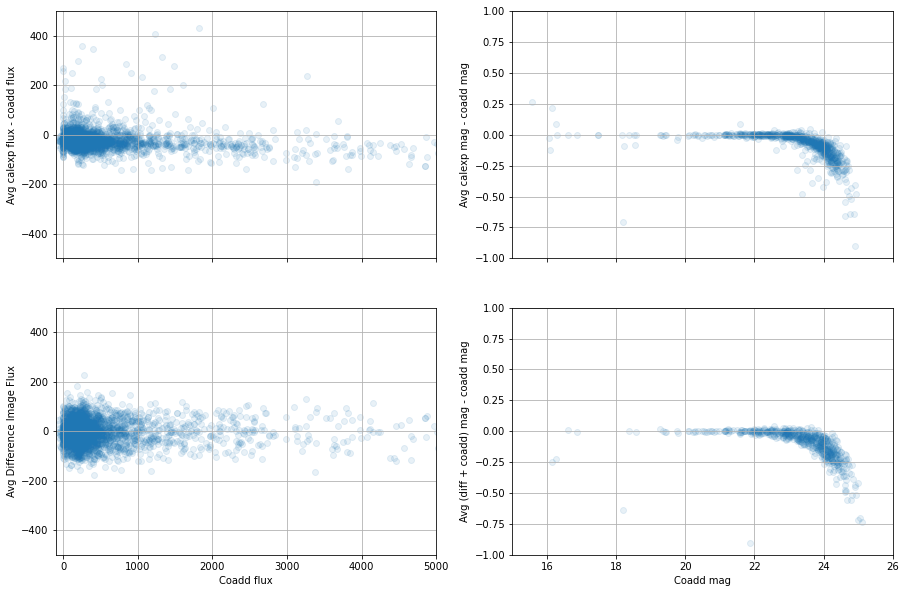

In [315]:
fig, subs = plt.subplots(2,2, figsize=(15,10), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(avg_df['refFlux'], avg_df['calexpFlux'] - avg_df['refFlux'], alpha=0.1)
subs[1,0].scatter(avg_df['refFlux'], avg_df['diffFlux'], alpha=0.1)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,0].set_ylim(-500, 500)
subs[0,0].set_xlim(-100, 5000)
subs[0,0].set_ylabel('Avg calexp flux - coadd flux')
subs[1,0].set_xlabel('Coadd flux')
subs[1,0].set_ylabel('Avg Difference Image Flux')
subs[0,1].scatter(avg_df['refMag'], avg_df['calexpMag'] - avg_df['refMag'], alpha=0.1)
subs[1,1].scatter(avg_df['refMag'], avg_df['diffMag'], alpha=0.1)
subs[0,1].set_ylabel('Avg calexp mag - coadd mag')
subs[0,1].grid(True)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Avg (diff + coadd) mag - coadd mag')
subs[1,1].set_ylim(-1,1)
subs[1,1].grid(True)
subs[0,1].set_xlim(15,26)

## Look at only objects with refExtendedness == 0:

(15.0, 26.0)

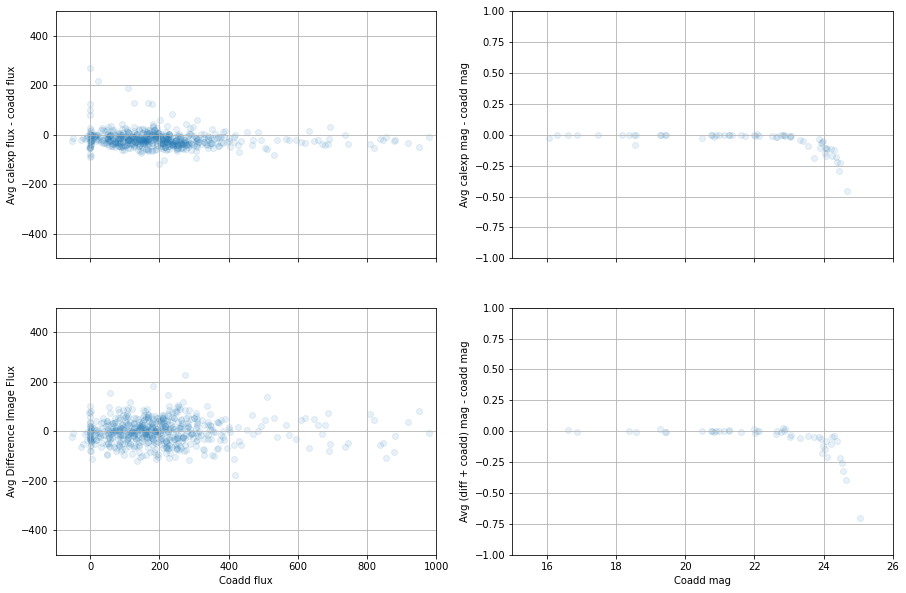

In [384]:
fig, subs = plt.subplots(2,2, figsize=(15,10), sharex='col', sharey='col', facecolor='w')
m = refCatalog[::10][:n]['refExtendedness'] == 0
subs[0,0].scatter(avg_df['refFlux'][m], (avg_df['calexpFlux'] - avg_df['refFlux'])[m], alpha=0.1)
subs[1,0].scatter(avg_df['refFlux'][m], avg_df['diffFlux'][m], alpha=0.1)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,0].set_ylim(-500, 500)
subs[0,0].set_xlim(-100, 1000)
subs[0,0].set_ylabel('Avg calexp flux - coadd flux')
subs[1,0].set_xlabel('Coadd flux')
subs[1,0].set_ylabel('Avg Difference Image Flux')
subs[0,1].scatter(avg_df['refMag'][m], (avg_df['calexpMag'] - avg_df['refMag'])[m], alpha=0.1)
subs[1,1].scatter(avg_df['refMag'][m], avg_df['diffMag'][m], alpha=0.1)
subs[0,1].set_ylabel('Avg calexp mag - coadd mag')
subs[0,1].grid(True)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Avg (diff + coadd) mag - coadd mag')
subs[1,1].set_ylim(-1,1)
subs[1,1].grid(True)
subs[0,1].set_xlim(15,26)

The above plots show that for both the calexps and the diffims, bright stars are on average measured to have the same fluxes and magnitude in the calexps as in the coadds, with flux~0 in the difference images, as would be expected. However, at fainter magnitudes, there is a bias where the average calexp magnitude is brighter than the magnitude in the coadd. In the diffims, there is a bias in the fainter objects towards positive flux measurements. This awaits interpretation.

### Same thing, but using the coadd_meas catalog: don't have this

# How much scatter is there between the calexp fluxes/magnitudes for the same object? Similarly, how much scatter is there between the diffim fluxes/magnitudes for the same object?

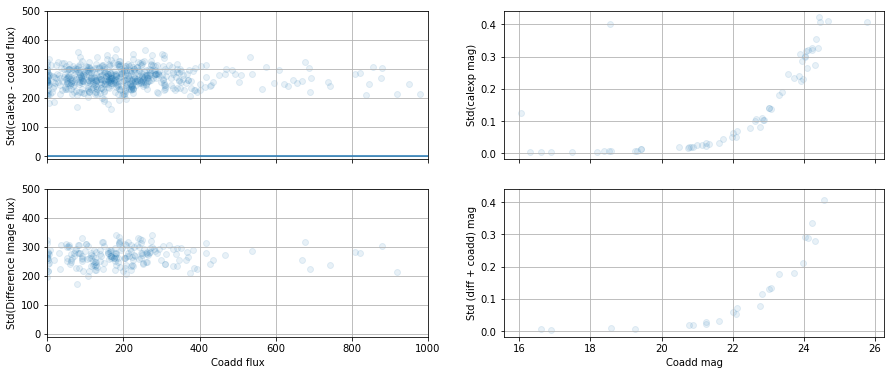

In [390]:
fig, subs = plt.subplots(2, 2, figsize=(15,6), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(avg_df['refFlux'][m], avg_df['calexpFluxStd'][m], alpha=0.1)
subs[0,0].axhline(0)
subs[1,0].set_xlabel('Coadd flux')
subs[0,0].set_ylabel('Std(calexp - coadd flux)')
subs[1,0].set_ylabel('Std(Difference Image flux)')
subs[1,0].scatter(avg_df['refFlux'][m], avg_df['diffFluxStd'][m], alpha=0.1)
subs[0,0].set_xlim(0, 1000)
subs[0,0].set_ylim(-10, 500)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,1].scatter(avg_df['refMag'][m], avg_df['calexpMagStd'][m], alpha=0.1)
subs[0,1].set_ylabel('Std(calexp mag)')
subs[0,1].grid(True)
subs[1,1].scatter(avg_df['refMag'][m], avg_df['diffMagStd'][m], alpha=0.1)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Std (diff + coadd) mag')
subs[1,1].grid(True)
#subs[1,1].set_ylim(-0.01,1.5)

In [ ]:
seeing_array = np.array([seeingDict[i]['calexp'] for i in range(lenCalexp)])
diff_seeing_array = np.array([seeingDict[i]['diffim'] for i in range(lenCalexp)])

In [ ]:
c = coadd.getPhotoCalib()

In [ ]:
def percentile16(x):
    return np.percentile(x, 16)m
def percentile84(x):
    return np.percentile(x, 84)

## Are there systematic differences between observations of the same object at different seeing levels? (objects with extendedness==0 only)
We split up the objects into bins in magnitude, then look at trends in the magnitude residuals in each bin.

[5165.12918028  562.98774567  637.62055336 ...    5.70525547   45.67838089
   61.56862953] nJy
76.23264545102458 15.36458940772166
Magnitudes = 15.00 - 17.00, 26 calexp objects


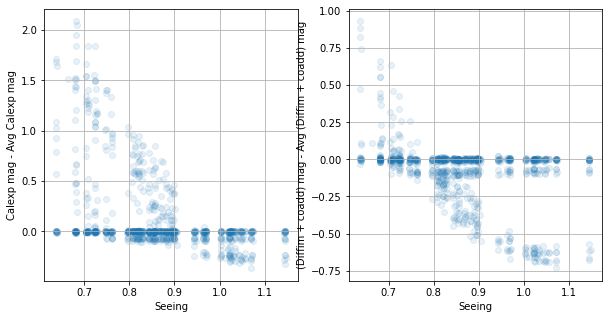

Magnitudes = 17.00 - 19.00, 72 calexp objects


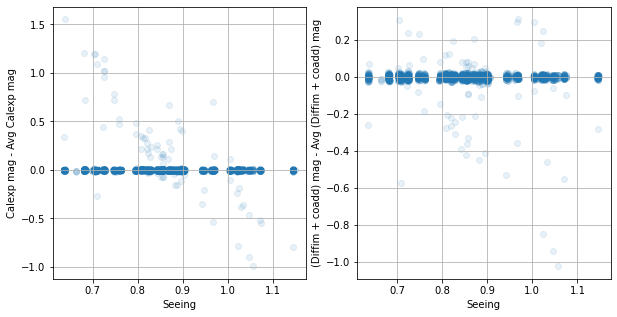

Magnitudes = 19.00 - 21.00, 144 calexp objects


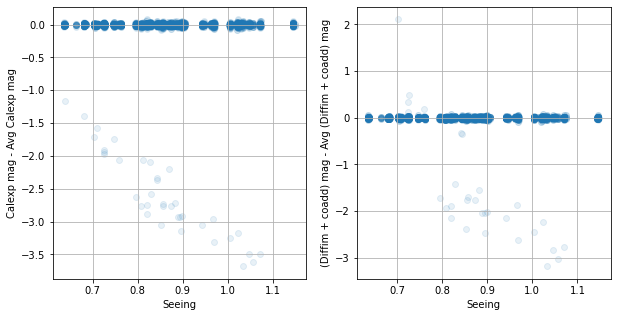

Magnitudes = 21.00 - 23.00, 177 calexp objects


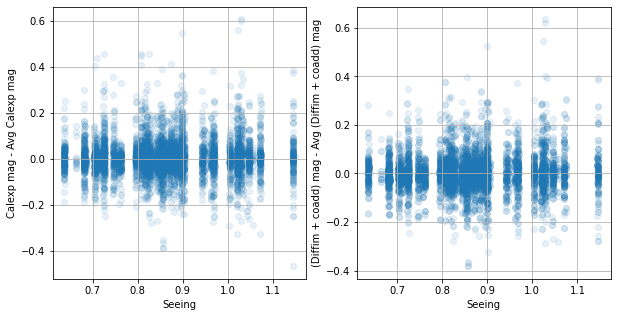

Magnitudes = 23.00 - 25.00, 668 calexp objects


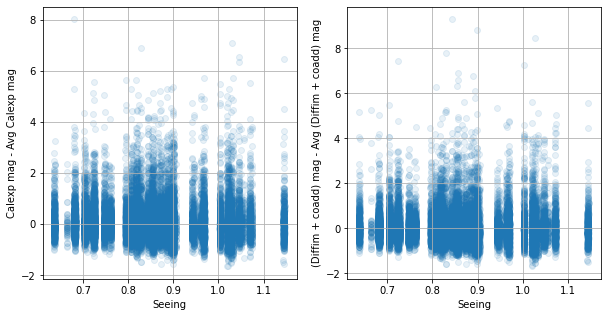

In [326]:
import warnings
warnings.filterwarnings('ignore')
meas_bins = np.arange(15, 27, 2)
meas_mag = (refCatalog[f'{band}_psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
print(meas_mag[np.isfinite(meas_mag)].max(), meas_mag[np.isfinite(meas_mag)].min())
for mm, m in enumerate(meas_bins[:-1]):
    mm_ind = (meas_mag > meas_bins[mm]) & (meas_mag < meas_bins[mm + 1]) & (refCatalog['refExtendedness'] == 0)
    mm_stars = refCatalog[mm_ind]
    print('Magnitudes = %.2f - %.2f,' % (m, m+2), '%s calexp objects' % len(mm_stars))

    seeings = []
    dmags = []
    diffs = []
    
    for s, star in mm_stars.iterrows():
        rc = star#refCatalog.loc[s]
        if rc['refExtendedness'] != 0:
            continue
        ref_mag = (rc[f'{band}_psfFlux'] * u.nJy).to(u.ABmag).to_value()
        rc_match = forced_src[(forced_src['objectId'] == s) & (forced_src['band'] == band)]
        star_seeing = [ccdVisitTable.loc[rc['ccdVisitId']]['seeing'] for r, rc in rc_match.iterrows()]
        seeings.extend(star_seeing)
        star_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
        dmags.extend(star_mags - ref_mag)
        star_diffs = ((rc_match['psfDiffFlux'] + rc[f'{band}_psfFlux']).to_numpy() * u.nJy).to(u.ABmag).to_value()
        diffs.extend(star_diffs - ref_mag)
    
    """
    plot_mags = mags[mm_ind]
    plot_ind = np.isfinite(mags[mm_ind]) & (magWeights[mm_ind] != 0) & (mags[mm_ind] != 0)
    plot_diffs = diffMags[mm_ind2]
    plot_diff_ind = np.isfinite(diffMags[mm_ind2]) & (diffMagWeights[mm_ind2] != 0)
    p16 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile16)
    p50 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=np.median)
    p84 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile84)
    """
    fig, subs = plt.subplots(1, 2, figsize=(10, 5))
    subs[0].scatter(seeings, dmags, alpha=0.1)
    subs[1].scatter(seeings, diffs, alpha=0.1)
    """
    subs[0].plot(p16[1][:-1] + 0.5 * np.diff(p16[1])[0], p16[0], linestyle='--', color='r')
    subs[0].plot(p50[1][:-1] + 0.5 * np.diff(p50[1])[0], p50[0], color='r')
    subs[0].plot(p84[1][:-1] + 0.5 * np.diff(p84[1])[0], p84[0], linestyle='--', color='r')
    if mm_ind2.sum() != 0:
        p16_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile16)
        p50_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=np.median)
        p84_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile84)
        subs[1].plot(p16_diff[1][:-1] + 0.5 * np.diff(p16_diff[1])[0], p16_diff[0], linestyle='--', color='r')
        subs[1].plot(p50_diff[1][:-1] + 0.5 * np.diff(p50_diff[1])[0], p50_diff[0], color='r')
        subs[1].plot(p84_diff[1][:-1] + 0.5 * np.diff(p84_diff[1])[0], p84_diff[0], linestyle='--', color='r')
    """
    #subs[0].set_ylim(-0.5, 0.5)
    #subs[1].set_ylim(-0.5, 0.5)
    subs[0].grid(True)
    subs[1].grid(True)
    subs[0].set_xlabel('Seeing')
    subs[1].set_xlabel('Seeing')
    subs[0].set_ylabel('Calexp mag - Avg Calexp mag')
    subs[1].set_ylabel('(Diffim + coadd) mag - Avg (Diffim + coadd) mag')
    plt.show()

## What is the $\chi^2/$dof of the lightcurves?

Assume a model in which the flux is constant. For the diffim lightcurves, the assumed model is a constant flux of zero.

In [341]:
rmags = []
calexp_chis = []
diff_chis = []
for s, star in refCatalog[::10][:n].iterrows():
    if star['refExtendedness'] != 0: continue
    rmags.append(avg_df.loc[s]['refMag'])
    rc_match = forced_src[(forced_src['objectId'] == s) & (forced_src['band'] == band)]
    calexp_chi = ((rc_match['psfFlux'] - avg_df.loc[s]['calexpFlux'])/rc_match['psfFluxErr'])**2
    lc_rchi = calexp_chi.sum() / len(rc_match)
    calexp_chis.append(lc_rchi)
    
    diff_chi = (rc_match['psfDiffFlux']/rc_match['psfDiffFluxErr'])**2
    lc_rchi = diff_chi.sum() / len(rc_match)
    diff_chis.append(lc_rchi)

Text(0.5, 1.0, 'Chi2 of diffim lightcurves (extendedness=0 objects only)')

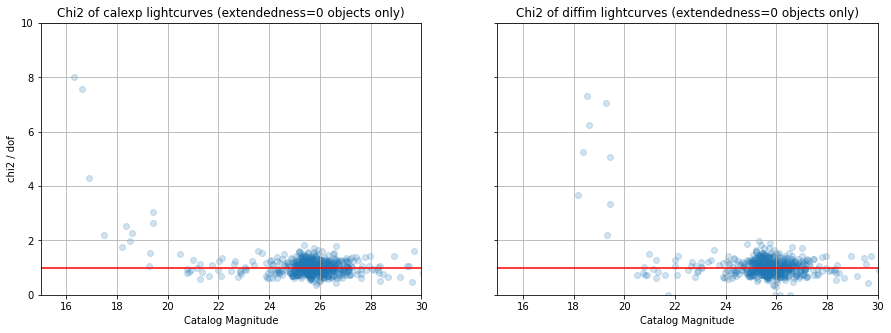

In [345]:
fig, subs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True, facecolor='w')
subs[0].scatter(rmags, calexp_chis, alpha=0.2)
subs[0].set_ylim(0, 10)
subs[0].set_xlim(15, 30)
subs[0].axhline(1, color='r')
subs[0].grid(True)
subs[0].set_ylabel('chi2 / dof')
subs[0].set_xlabel('Catalog Magnitude')
subs[0].set_title('Chi2 of calexp lightcurves (extendedness=0 objects only)')

subs[1].scatter(rmags, diff_chis, alpha=0.2)
subs[1].axhline(1, color='r')
subs[1].grid(True)
subs[1].set_xlabel('Catalog Magnitude')
subs[1].set_title('Chi2 of diffim lightcurves (extendedness=0 objects only)')

# Appendix

### Make some lightcurves of random point source objects

In [249]:
from astropy.time import Time

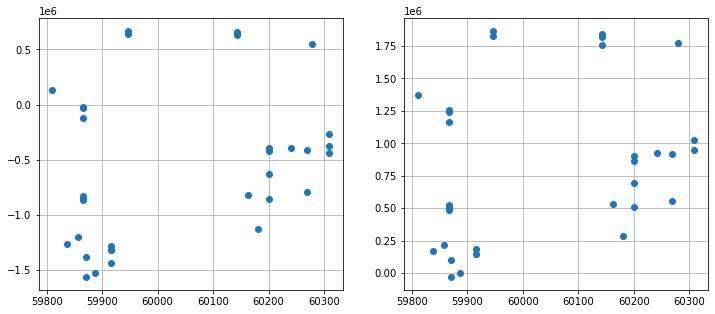

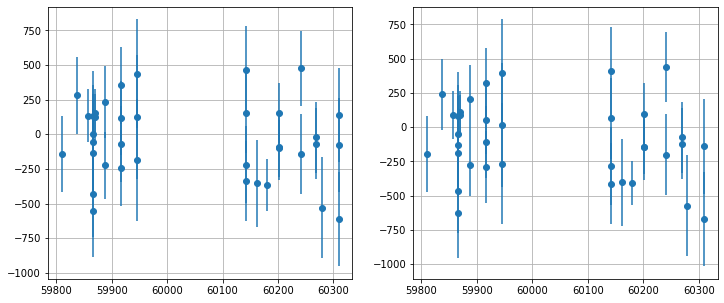

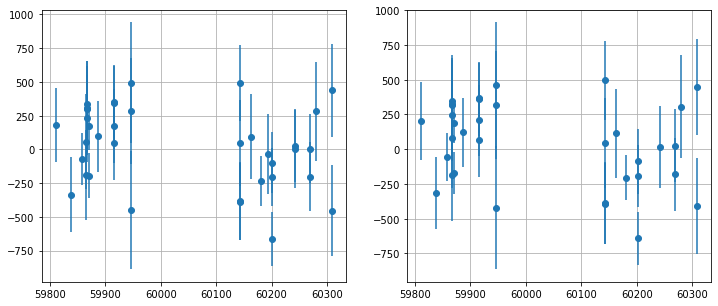

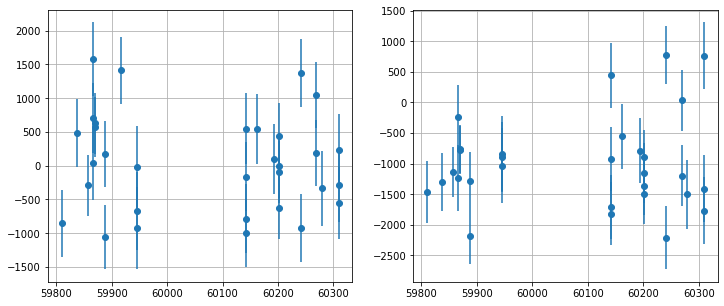

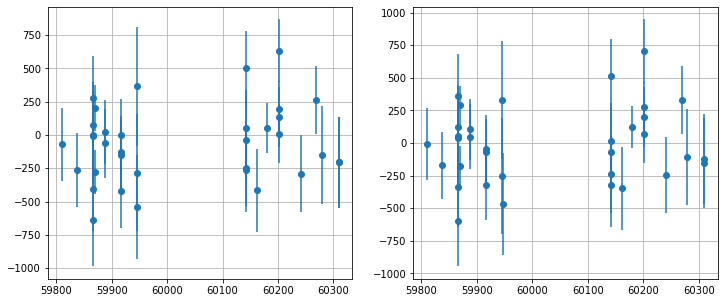

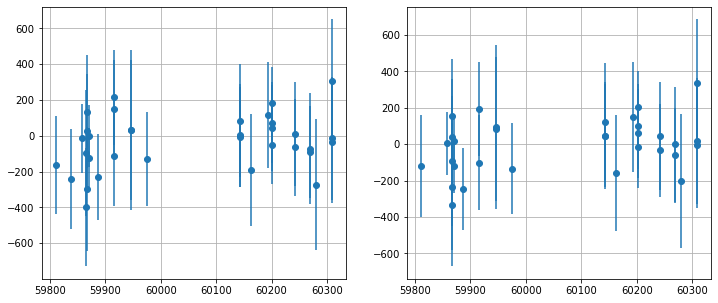

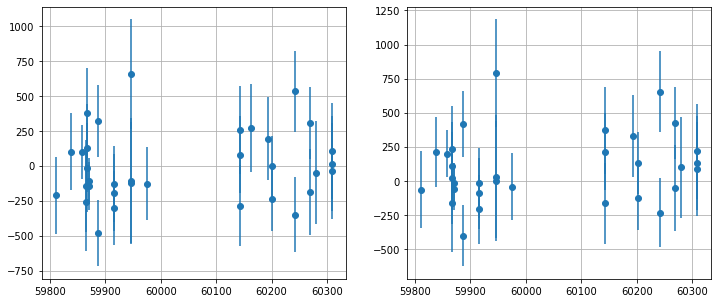

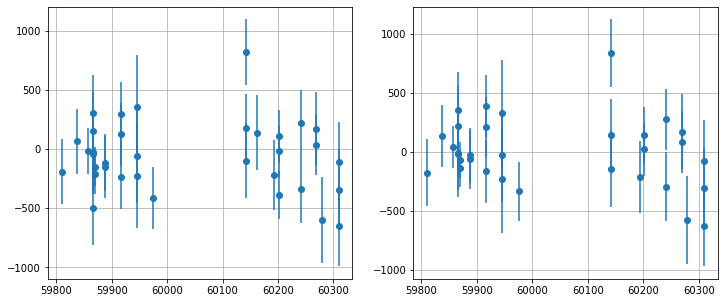

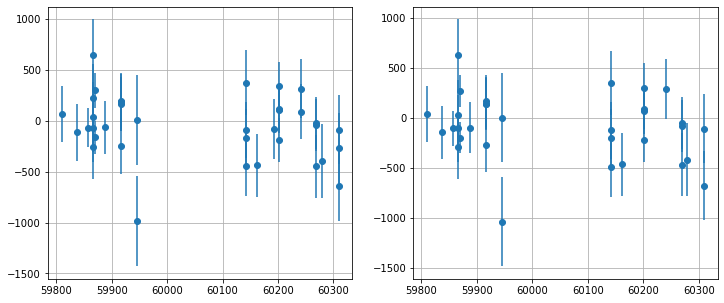

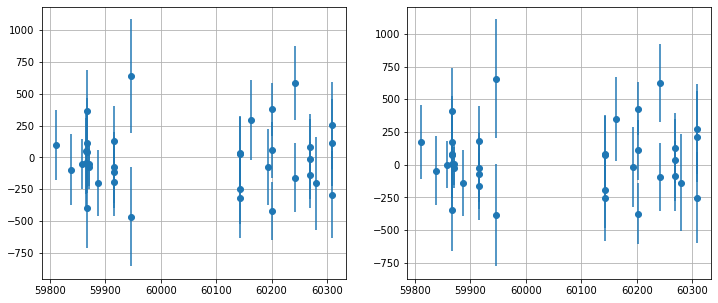

In [262]:
stars = refCatalog[refCatalog['refExtendedness'] == 0]
for s, star in stars[::10][:10].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == s) & (forced_src['band'] == band)]
    obs_time = [Time(ccdVisitTable.loc[rc['ccdVisitId']]['expMidpt']).mjd for r, rc in rc_match.iterrows()]
    fig, subs = plt.subplots(1,2, figsize=(12, 5), sharex=True)
    subs[0].errorbar(obs_time, rc_match['psfFlux'] - star[f'{band}_psfFlux'], yerr = rc_match['psfFluxErr'],
                     linestyle="None", marker='o')
    subs[1].errorbar(obs_time, rc_match['psfDiffFlux'], yerr = rc_match['psfDiffFluxErr'],
                     linestyle="None", marker='o')
    subs[0].grid(True)
    subs[1].grid(True)

### What do the objects with large scatter in their magnitudes look like?

### Here are some weird ones:

11
RA = 55.75059302520934 Dec = -36.30736697409101
Mag = 16.163334662943555
Extendedness = nan Blendedness (i) = 0.0


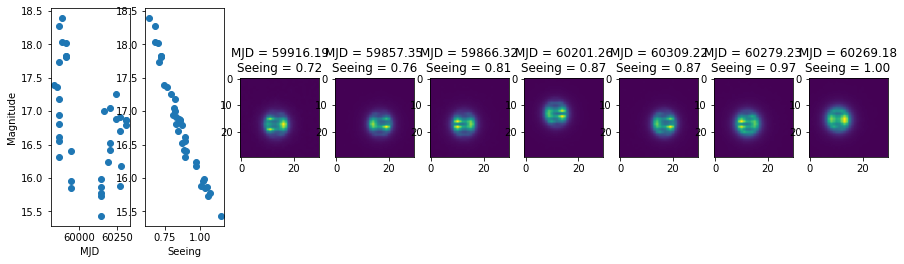

RA = 55.92184118001674 Dec = -36.251889665789186
Mag = 16.26554894681724
Extendedness = nan Blendedness (i) = 0.0


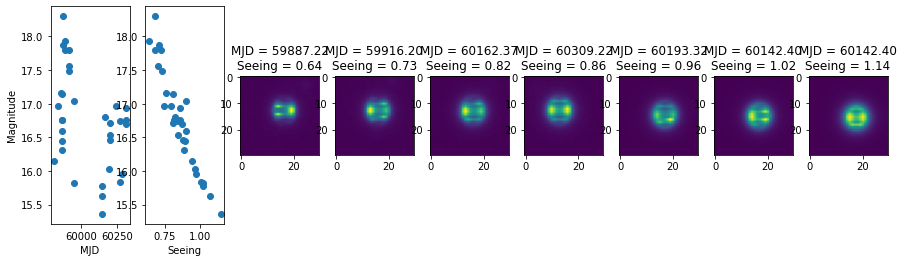

RA = 55.914106767923315 Dec = -36.22730828424356
Mag = 18.227886022432795
Extendedness = nan Blendedness (i) = 0.0


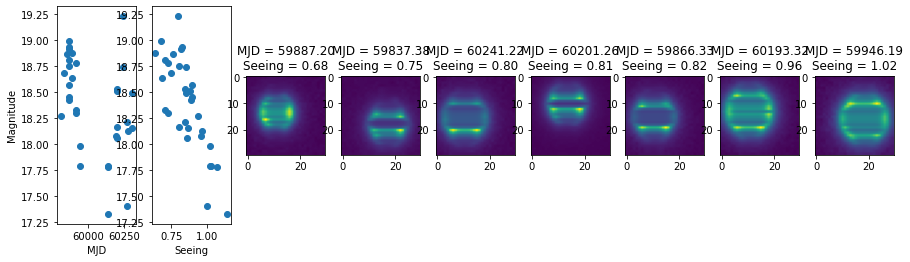

RA = 55.80346736694046 Dec = -36.17853781958659
Mag = 19.368825630947846
Extendedness = 1.0 Blendedness (i) = 0.0


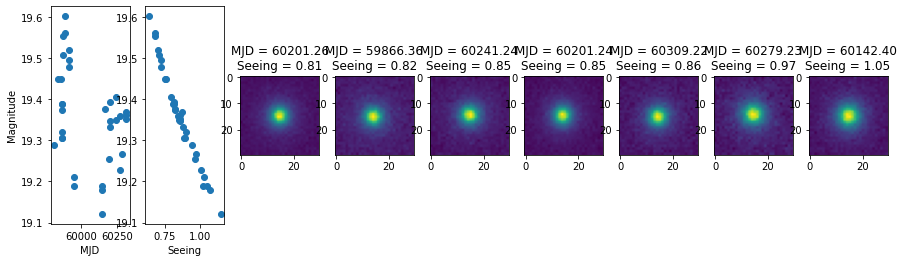

RA = 55.931881892319225 Dec = -36.13444761424512
Mag = 16.052350784145474
Extendedness = 0.0 Blendedness (i) = 0.0


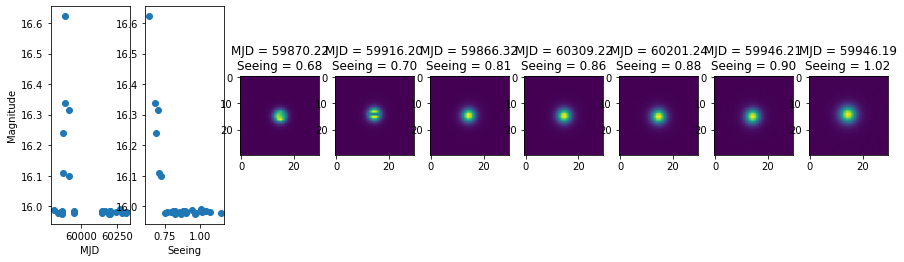

RA = 55.80864587635423 Dec = -36.12075203077788
Mag = 18.546252093012466
Extendedness = 0.0 Blendedness (i) = 0.0


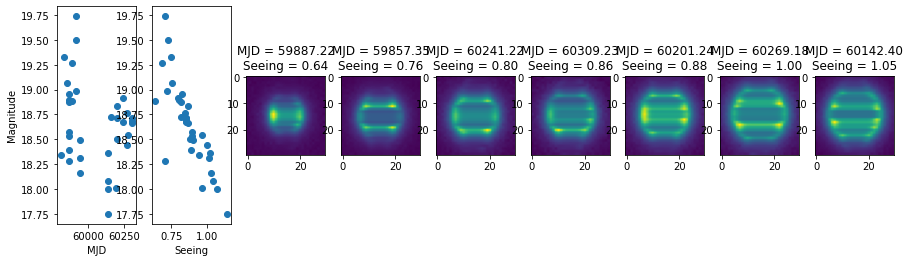

RA = 55.81209691565446 Dec = -36.33323854430629
Mag = 15.567418850453596
Extendedness = 1.0 Blendedness (i) = -0.008508668885066406


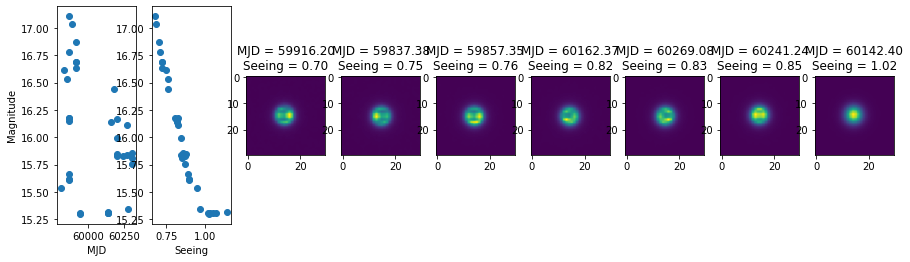

RA = 55.74021911093399 Dec = -36.33313944442834
Mag = 16.09559409426816
Extendedness = 1.0 Blendedness (i) = 0.06781355562903313


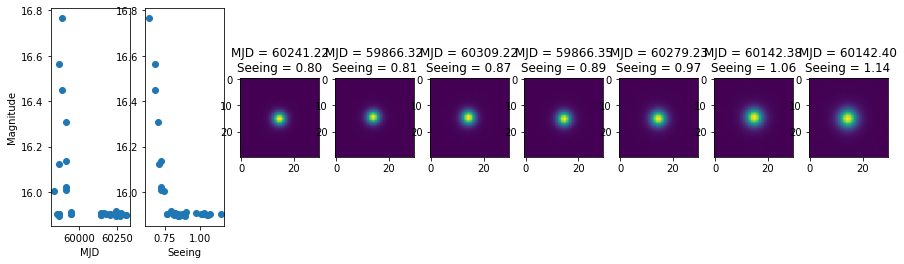

RA = 55.704094262081384 Dec = -36.27646620812652
Mag = 18.198798899706397
Extendedness = nan Blendedness (i) = 0.5092798894926662


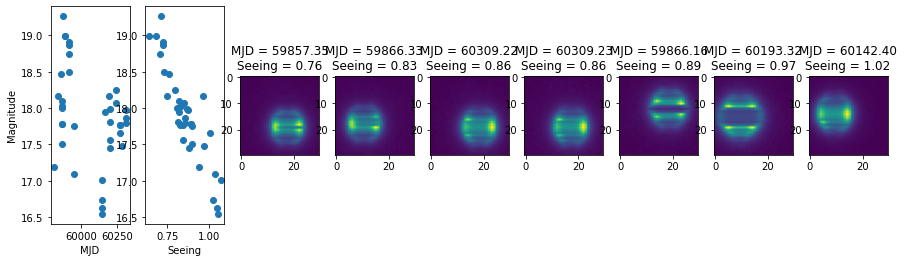

RA = 55.75435686580987 Dec = -36.16903479203636
Mag = 19.75308158187842
Extendedness = 1.0 Blendedness (i) = 0.044455052981102305


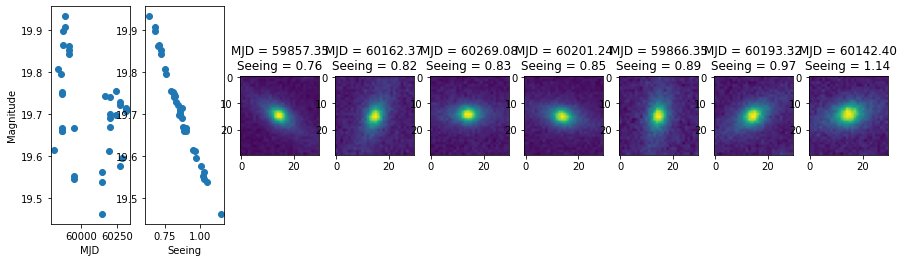

RA = 55.7887210566423 Dec = -36.12047741814973
Mag = 19.77805630011528
Extendedness = 1.0 Blendedness (i) = 0.0158542420542519


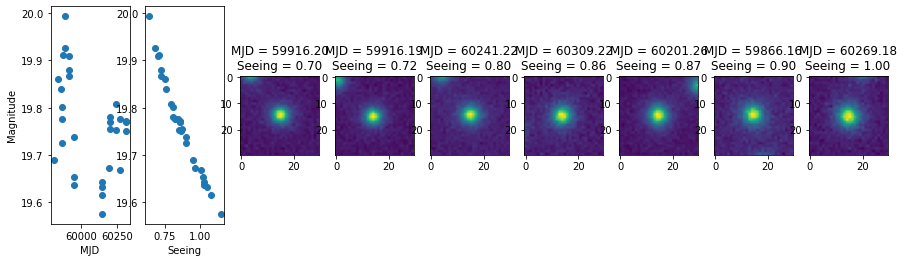

In [403]:
weird_objects = avg_df[(avg_df['refMag'] < 20) & (avg_df['calexpMagStd'] > 0.1)]
print(len(weird_objects))
num_thumbs = 7
for ind, obj in weird_objects[:20].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == ind) & (forced_src['band'] == band)]
    calexp_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
    ccdvisits = ccdVisitTable.loc[rc_match['ccdVisitId']]
    mjds = Time(ccdvisits['expMidpt']).mjd
    seeings = ccdvisits['seeing'].to_numpy()
    seeing_order = seeings.argsort()
    fig, subs = plt.subplots(1, 2 + num_thumbs, figsize=(15, 4))
    subs[0].scatter(mjds, calexp_mags)
    subs[0].set_xlabel('MJD')
    subs[0].set_ylabel('Magnitude')
    subs[1].scatter(seeings[seeing_order], calexp_mags[seeing_order])
    subs[1].set_xlabel('Seeing')
    print("RA =", rc_match.iloc[0]['coord_ra'], "Dec =", rc_match.iloc[0]['coord_dec'])
    print("Mag =", obj['refMag'])
    rCat = refCatalog.loc[ind]
    print("Extendedness =", rCat['refExtendedness'], f"Blendedness ({band}) =", rCat[f'{band}_blendedness'])
    center = geom.SpherePoint(rc_match.iloc[0]['coord_ra'], rc_match.iloc[0]['coord_dec'], geom.degrees)
    extent = geom.Extent2I(30, 30)
    i = 2
    random_visit = np.random.choice(len(rc_match), num_thumbs, replace=False)
    random_sort = seeings[random_visit].argsort()
    for c, ccdvisit in ccdvisits.iloc[random_visit[random_sort]].iterrows():
        calexp = butler.get('calexp', tract=tract, band=band, detector=ccdvisit['detector'],
                            visit=ccdvisit['visitId'])
        thumb = calexp.getCutout(center, extent)
        subs[i].imshow(thumb.image.array)
        subs[i].set_title(f"MJD = {Time(ccdvisit['expMidpt']).mjd:.2f}\nSeeing = {ccdvisit['seeing']:.2f}")
        i += 1
        if i == num_thumbs + 2:
            break
    plt.show()

### Some normal ones for comparison:

13
RA = 55.783771420719916 Dec = -36.31352820698047
Mag = 19.42854641296764
Extendedness = 0.0 Blendedness (i) = 0.0


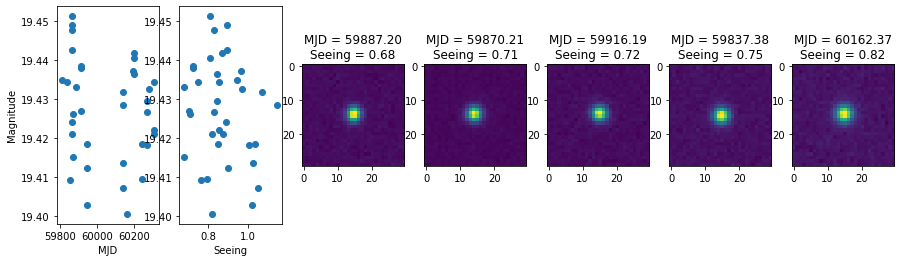

RA = 55.736312739498565 Dec = -36.27643672302548
Mag = 16.885254869367763
Extendedness = 0.0 Blendedness (i) = 0.0


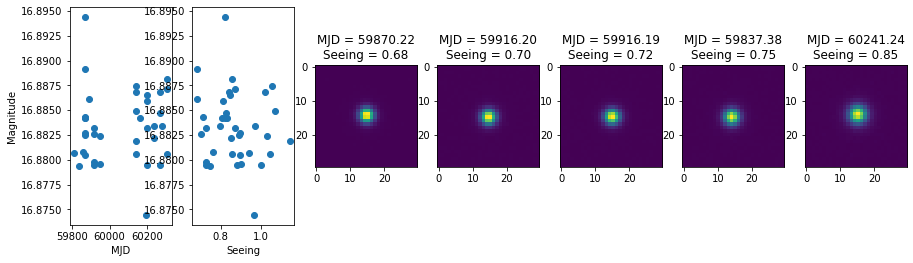

RA = 55.90250626212694 Dec = -36.27664157258792
Mag = 18.371265733427155
Extendedness = 0.0 Blendedness (i) = 0.0


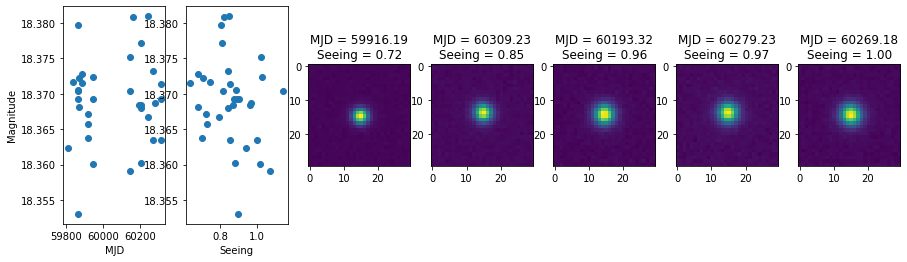

RA = 55.76692740389674 Dec = -36.26440853619286
Mag = 19.25854618676697
Extendedness = 0.0 Blendedness (i) = 0.0


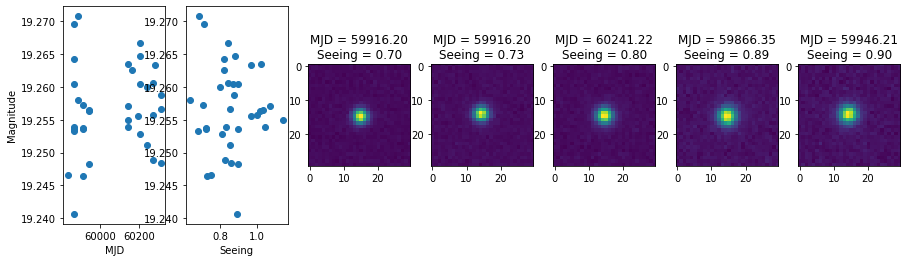

RA = 55.92717497163534 Dec = -36.239613881850765
Mag = 16.287714572624072
Extendedness = 0.0 Blendedness (i) = 0.0


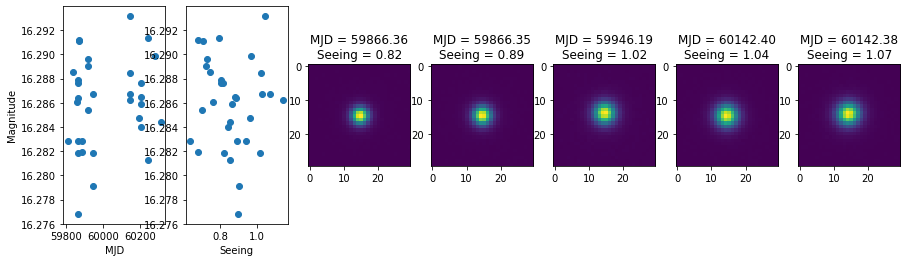

In [405]:
normal_objects = avg_df[(avg_df['refMag'] < 20) & (avg_df['calexpMagStd'] < 0.1)]
print(len(normal_objects))
num_thumbs = 5
for ind, obj in normal_objects[:5].iterrows():
    rc_match = forced_src[(forced_src['objectId'] == ind) & (forced_src['band'] == band)]
    calexp_mags = (rc_match['psfFlux'].to_numpy() * u.nJy).to(u.ABmag).to_value()
    ccdvisits = ccdVisitTable.loc[rc_match['ccdVisitId']]
    mjds = Time(ccdvisits['expMidpt']).mjd
    seeings = ccdvisits['seeing'].to_numpy()
    seeing_order = seeings.argsort()
    fig, subs = plt.subplots(1, 2 + num_thumbs, figsize=(15, 4))
    subs[0].scatter(mjds, calexp_mags)
    subs[0].set_xlabel('MJD')
    subs[0].set_ylabel('Magnitude')
    subs[1].scatter(seeings[seeing_order], calexp_mags[seeing_order])
    subs[1].set_xlabel('Seeing')
    print('RA =', rc_match.iloc[0]['coord_ra'], 'Dec =', rc_match.iloc[0]['coord_dec'])
    print("Mag =", obj['refMag'])
    rCat = refCatalog.loc[ind]
    print("Extendedness =", rCat['refExtendedness'], f"Blendedness ({band}) =", rCat[f'{band}_blendedness'])
    center = geom.SpherePoint(rc_match.iloc[0]['coord_ra'], rc_match.iloc[0]['coord_dec'], geom.degrees)
    extent = geom.Extent2I(30, 30)
    i = 2
    random_visit = np.random.choice(len(rc_match), num_thumbs, replace=False)
    random_sort = seeings[random_visit].argsort()
    for c, ccdvisit in ccdvisits.iloc[random_visit[random_sort]].iterrows():
        calexp = butler.get('calexp', tract=tract, band=band, detector=ccdvisit['detector'],
                            visit=ccdvisit['visitId'])
        thumb = calexp.getCutout(center, extent)
        subs[i].imshow(thumb.image.array)
        subs[i].set_title(f"MJD = {Time(ccdvisit['expMidpt']).mjd:.2f}\nSeeing = {ccdvisit['seeing']:.2f}")
        i += 1
        if i == 7:
            break
    plt.show()

### What is the range of blendedness values?

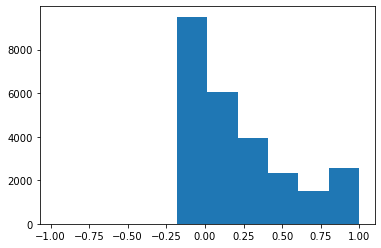

In [336]:
plt.hist(refCatalog[f'{band}_blendedness']);

### What is the range of extendedness values?

(array([ 6211.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 22638.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

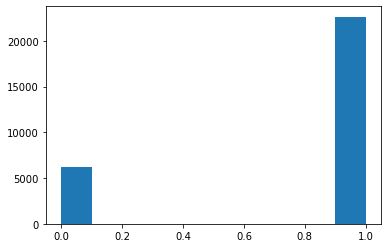

In [327]:
plt.hist(refCatalog['refExtendedness'])